In [2]:
# Import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# pytorch 및 MNIST 관련 라이브러리들을 불러옴
# 학습에 필요한 데이터 셋, 신경망 모듈, 손실 함수 등을 사용하기 위함

In [3]:
# Set processing unit
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# MNIST 데이터셋을 불러옴
# 학습용과 테스트용 데이터를 각각 로드, 이미지를 tensor 형식으로 변환

In [4]:
# Set seeds of random variables
torch.manual_seed(777)
if device == 'cuda:0':
    torch.cuda.manual_seed_all(777)

# 데이터 로더 생성
# 배치 단위로 데이터를 불러오고 셔플 여부를 설정 

In [25]:
# Model training settings
batch_size = 32
n_epochs = 20
lr = 0.01 # learning rate
momentum = 0.5

# 다층 퍼셉트론(MLP) 모델 클래스를 정의
# 총 3개의 liner 계층과 ReLU 활성화 함수로 구

In [27]:
# MNIST dataset preparation
train_dataset = datasets.MNIST(root='./data/MNIST', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data/MNIST', train=False, download=True, transform=transforms.ToTensor())

# Load MNIST feeder
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# 모델 객체 생성
# 크로스 엔트로피 손실 함수와 Adam 옵티마이저 설

X_train: torch.Size([32, 1, 28, 28]), type: <built-in method type of Tensor object at 0x0000028DB4A79270>
y_train: torch.Size([32]), type: <built-in method type of Tensor object at 0x0000028DB4A79E00>


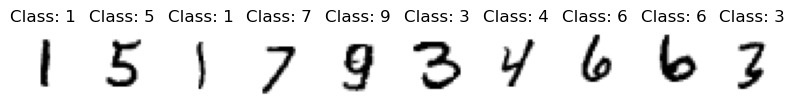

In [29]:
# Check MNIST dataset
for (X_train, y_train) in train_loader:
    print('X_train: {}, type: {}'.format(X_train.size(), X_train.type))
    print('y_train: {}, type: {}'.format(y_train.size(), y_train.type))
    break

plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap='gray_r')
    plt.title('Class: {}'.format(str(y_train[i].item())))
plt.show()

# 본격적인 학습 루프
# 에포크를 돌며 각 배치에서 예측값을 구하고 손실을 계산, 역전파 backpropagation으로 파라미터 업데이

In [8]:
# Define network architecture
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512) # (N, 784, 512), N - batch_size
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x): # Forward propagation
        x = x.view(-1, 28 * 28) # (N, 28, 28) -> (N, 784)
        output = self.fc1(x) # (N, 784) -> (N, 512)
        output = F.sigmoid(output)
        output = self.fc2(output) # (N, 512) -> (512, 256)
        output = F.sigmoid(output)
        output = self.fc3(output) # (N, 256) -> (N, 10)
        output = F.log_softmax(output, dim=1) # 256 logits -> probability distribution (10 classes)
        return output       

# 학습이 끝난 후 테스트 데이터셋을 사용해서 모델의 정확도 평

In [9]:
# Prepare model training
model = MultiLayerPerceptron().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# 개별 테스트 이미지에 대한 예측 결과를 시각화 하기 위한 atplotlib 사용 드

In [10]:
# Train the model
def train(model, train_loader, optimizer, log_interval=5):
    model.train()
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (idx + 1) % log_interval == 0:
            print('Train epoch: [{}/{} ({:.2f}%)]\tTrain Loss: {:.6f}'.format(idx * len(x), len(train_loader.dataset), 100. * idx / len(train_loader), loss.item()))

# 앞서 정의한 시각화 함수 imshow를 활용해 테스트 이미지 하나와 그 예측 결과를 출

In [11]:
# Evaluate the model
def evaluate(model, test_loader):
    model.eval()
    test_loss = .0
    correct = 0

    with torch.no_grad():
        for x, y in tqdm(test_loader):
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            test_loss += criterion(output, y).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(y.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset) / batch_size
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

# 전체 테스트셋에 대해 예측값과 정답을 비교, 클래스별로 정확도를 계

In [12]:
for epoch in range(n_epochs):
    train(model, train_loader, optimizer, log_interval=10000)
    test_loss, accuracy = evaluate(model, test_loader)
    print("\n[Epoch: {}], \tTest Loss: {:.4f},\tAccuracy: {:.2f} %\n".format(epoch, test_loss, accuracy))

# 예측 결과를 confusion matrix로 시각화 해서 어떤 숫자에서 오류가 많이 나는지를 확인

1875it [00:10, 185.89it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 238.38it/s]



[Epoch: 0], 	Test Loss: 2.2360,	Accuracy: 22.96 %



1875it [00:09, 188.96it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 238.59it/s]



[Epoch: 1], 	Test Loss: 1.2072,	Accuracy: 67.09 %



1875it [00:10, 180.79it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 216.59it/s]



[Epoch: 2], 	Test Loss: 0.7357,	Accuracy: 78.35 %



1875it [00:11, 161.18it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 226.54it/s]



[Epoch: 3], 	Test Loss: 0.5486,	Accuracy: 84.19 %



1875it [00:10, 179.51it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 216.15it/s]



[Epoch: 4], 	Test Loss: 0.4513,	Accuracy: 86.90 %



1875it [00:10, 185.40it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 247.71it/s]



[Epoch: 5], 	Test Loss: 0.4004,	Accuracy: 88.47 %



1875it [00:09, 197.54it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 243.91it/s]



[Epoch: 6], 	Test Loss: 0.3747,	Accuracy: 89.09 %



1875it [00:09, 189.91it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 240.98it/s]



[Epoch: 7], 	Test Loss: 0.3605,	Accuracy: 89.59 %



1875it [00:09, 188.62it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 244.48it/s]



[Epoch: 8], 	Test Loss: 0.3454,	Accuracy: 90.02 %



1875it [00:10, 184.70it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 239.39it/s]



[Epoch: 9], 	Test Loss: 0.3337,	Accuracy: 90.42 %



1875it [00:09, 190.20it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 242.71it/s]



[Epoch: 10], 	Test Loss: 0.3267,	Accuracy: 90.52 %



1875it [00:09, 190.28it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 246.18it/s]



[Epoch: 11], 	Test Loss: 0.3168,	Accuracy: 90.92 %



1875it [00:09, 188.17it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 242.23it/s]



[Epoch: 12], 	Test Loss: 0.3118,	Accuracy: 91.13 %



1875it [00:09, 190.04it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 236.51it/s]



[Epoch: 13], 	Test Loss: 0.3077,	Accuracy: 91.19 %



1875it [00:09, 190.32it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 237.91it/s]



[Epoch: 14], 	Test Loss: 0.2958,	Accuracy: 91.42 %



1875it [00:10, 186.64it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 234.85it/s]



[Epoch: 15], 	Test Loss: 0.2962,	Accuracy: 91.52 %



1875it [00:09, 189.68it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 238.67it/s]



[Epoch: 16], 	Test Loss: 0.2853,	Accuracy: 91.78 %



1875it [00:10, 181.67it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 241.96it/s]



[Epoch: 17], 	Test Loss: 0.2789,	Accuracy: 92.03 %



1875it [00:11, 160.72it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 234.58it/s]



[Epoch: 18], 	Test Loss: 0.2770,	Accuracy: 92.11 %



1875it [00:10, 185.49it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 228.09it/s]


[Epoch: 19], 	Test Loss: 0.2677,	Accuracy: 92.18 %



In [ ]:
# 📌 1. 학습률 증가의 본질: 오차역전파 + 가중치 갱신

# 매 에포크마다 모델은 다음을 반복합니다:

# 순전파 (Forward Propagation)
# → 입력 이미지가 모델을 통과하며 예측값 생성

# 손실 계산 (Loss Calculation)
# → 예측값과 정답 간의 차이를 손실 함수로 계산

# 역전파 (Backpropagation)
# → 손실을 기준으로 각 가중치가 얼마나 영향을 미쳤는지를 계산 (미분)

# 가중치 갱신 (Weight Update)
# → 계산된 그라디언트를 바탕으로 optimizer.step()을 통해 가중치 조정

# 이 과정을 반복할수록 모델은 점점 더 나은 가중치 조합을 찾아가기 때문에, 이전보다 더 정확하게 숫자를 분류하게 됩니다.


In [ ]:
# 📌 2. 매번 조금씩만 상승하는 이유
# 랜덤 초기값 + 미세한 학습률:
# 학습률(learning rate)이 너무 크면 오히려 튀는 결과를 낼 수 있어 일반적으로 작게 설정합니다 (0.001 등). 그래서 가중치 변화 폭이 작고, 매 에포크마다 조금씩만 좋아집니다.

# 모델이 이미 쉽게 맞추는 것들은 반복학습에 큰 영향을 주지 않음:
# 예를 들어 ‘0’이나 ‘1’ 같은 잘 구분되는 숫자는 초기에 잘 맞추지만, ‘3’과 ‘5’, ‘8’과 ‘9’ 같은 비슷한 이미지는 반복학습을 통해 천천히 구별되기 시작합니다.

# 로컬 미니멈/평탄한 구간:
# 손실 함수 지형이 복잡할 수 있어서, 모델이 천천히 고점에서 내려오거나 평탄한 구간에서 조금씩만 손실을 줄이게 됩니다.

In [ ]:
# 📌 3. 더 빠르게 오르도록 하려면?
# 더 깊은 신경망(CNN 등)
# MLP는 입력 전체를 펼쳐서 학습하므로 공간 정보(위치, 구조)를 잃습니다. CNN은 이 정보를 보존하면서 학습하기 때문에 정확도가 훨씬 빠르게 오르고, 더 높게 도달할 수 있습니다.

# 데이터 전처리 향상
# 정규화(Normalization)나 Data Augmentation(회전, 뒤집기 등)이 적용되면 학습 속도와 정확도가 좋아질 수 있습니다.

# 적절한 하이퍼파라미터 조정
# 예를 들어 학습률이나 배치 크기를 조절하거나, 옵티마이저를 SGD → Adam으로 바꾸는 것만으로도 학습 속도가 달라질 수 있습니다.

In [ ]:
# ✅ 요약
# 학습 정확도가 점차 상승하는 이유는, 오차역전파와 그라디언트 하강법을 통해 모델이 점차 더 나은 가중치를 찾기 때문이며, 소폭씩 증가하는 이유는 학습률, 손실 지형, 난이도 높은 샘플 등에 기인합니다.